In [ ]:
# !pip install kaggle

In [ ]:
# from google.colab import files
# files.upload()


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("brarajit18/student-feedback-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-feedback-dataset' dataset.
Path to dataset files: /kaggle/input/student-feedback-dataset


In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# !kaggle datasets download brarajit18/student-feedback-dataset --unzip


### 1. Setup and Data Loading
Load libraries, download stopwords, and read the feedback dataset.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# to remove stopwords for easy text analysis
try:
    nltk.download('stopwords', quiet=True)
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
except:
    stop_words = set()
# import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# import os

# download_path = "/root/.cache/kagglehub/datasets/brarajit18/student-feedback-dataset/versions/1"
# if os.path.exists(download_path):
#     print("Files in the downloaded dataset directory:")
#     for filename in os.listdir(download_path):
#         print(filename)
# else:
#     print(f"Download directory not found: {download_path}")

## Student Event Feedback Sentiment Analysis


### 2. Data Cleaning
Standardize columns, handle missing values, and prepare the data for analysis.


In [ ]:
# Loading dataset
df = pd.read_excel('/kaggle/input/student-feedback-dataset/finalDataset0.2.xlsx')
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (185, 12)
   teaching                                         teaching.1  coursecontent  \
0         0  teacher are punctual but they should also give...            0.0   
1         1                                              Good            -1.0   
2         1  Excellent lectures are delivered by teachers a...            1.0   
3         1                                               Good           -1.0   
4         1  teachers give us all the information required ...            1.0   

                                     coursecontent.1  examination  \
0                     content of courses are average          1.0   
1                                           Not good          1.0   
2  All courses material provide very good knowled...          1.0   
3  Content of course is perfectly in line with th...         -1.0   
4           content of courses improves my knowledge          1.0   

                                         Examination  labwork  \
0       

In [ ]:
# Clean column names and drop incomplete rows
df.columns = [col.strip() for col in df.columns]
df = df.dropna(subset=['teaching', 'teaching.1'])
df.reset_index(drop=True, inplace=True)
print("\nDataset info:")
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

from textblob import TextBlob

df['text_length'] = df['teaching.1'].apply(lambda x: len(str(x).split()))
df['polarity'] = df['teaching.1'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)




Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   teaching            185 non-null    int64  
 1   teaching.1          185 non-null    object 
 2   coursecontent       184 non-null    float64
 3   coursecontent.1     185 non-null    object 
 4   examination         184 non-null    float64
 5   Examination         185 non-null    object 
 6   labwork             185 non-null    int64  
 7   labwork.1           185 non-null    object 
 8   library_facilities  182 non-null    float64
 9   library_facilities  185 non-null    object 
 10  extracurricular     185 non-null    int64  
 11  extracurricular.1   185 non-null    object 
dtypes: float64(3), int64(3), object(6)
memory usage: 17.5+ KB
None

Missing values:
 teaching              0
teaching.1            0
coursecontent         1
coursecontent.1       0
examination 

### 3. Text Preprocessing
Remove punctuation, special characters, and stopwords from the feedback text.


In [ ]:
def preprocess_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    lemmatizer = WordNetLemmatizer()
    # Custom stopwords list to keep negations and important opinion words
    custom_stop = set(stopwords.words('english'))
    keep_words = {"not", "no", "never", "need", "improvement", "worst", "poor", "bad", "good", "excellent"}
    stopwords_final = custom_stop - keep_words
    words = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords_final and len(word) > 2]
    return ' '.join(words)


### 4. Exploratory Data Analysis (EDA)
Visualize sentiment label distributions for each feedback category in the dataset.


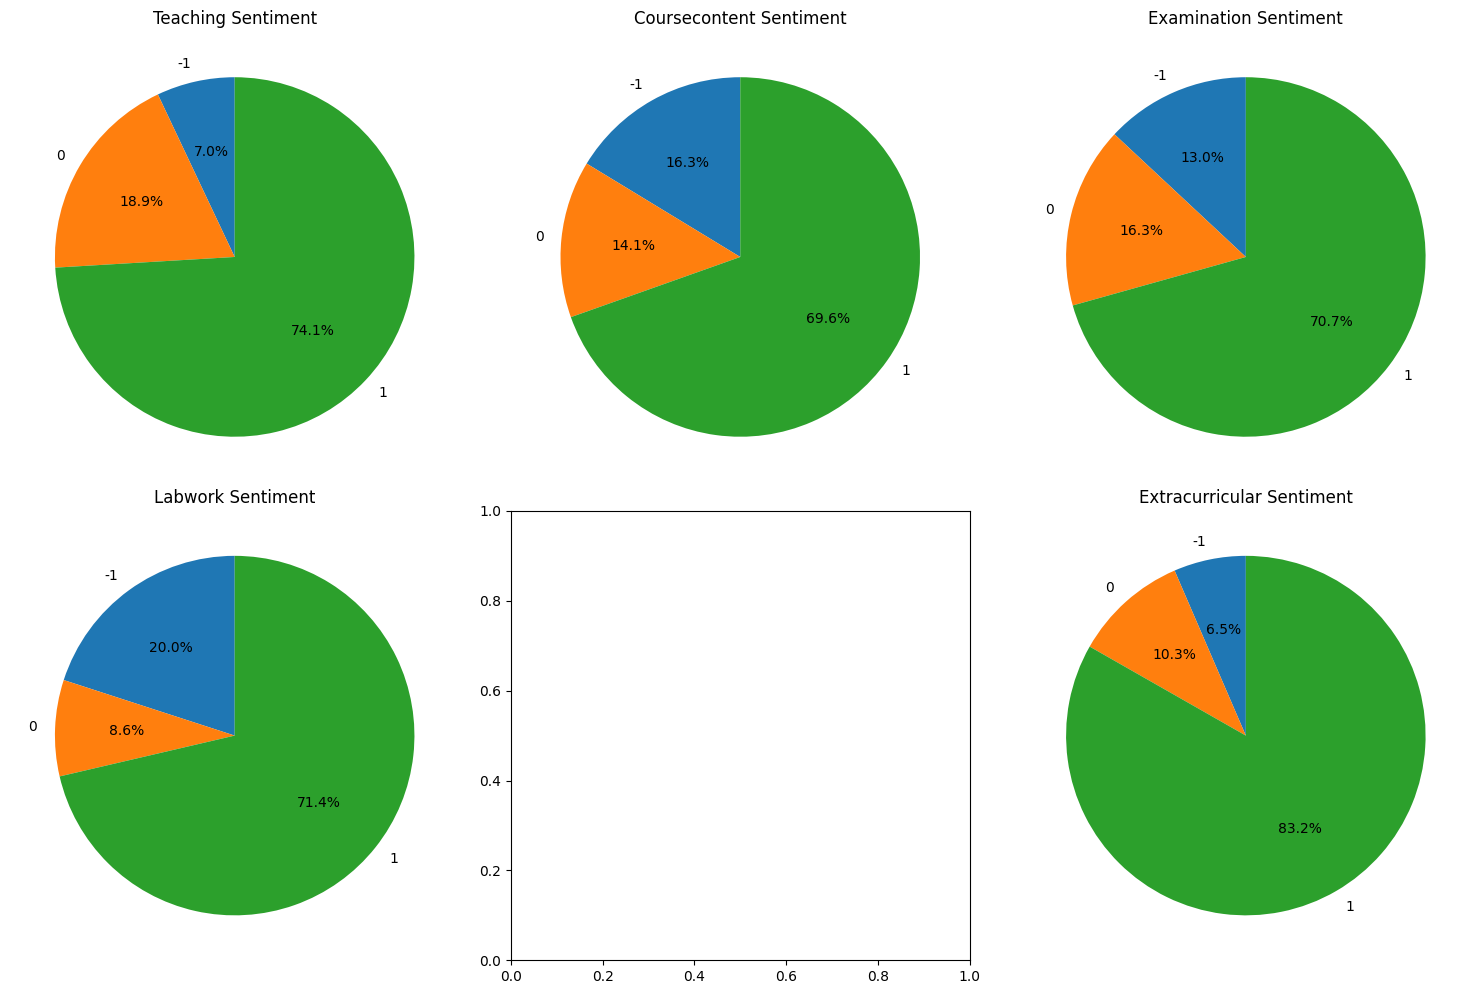

In [ ]:
import matplotlib.pyplot as plt

sentiment_cols = ['teaching', 'coursecontent', 'examination', 'labwork', ' library_facilities', 'extracurricular']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(sentiment_cols):
    if col in df.columns:
        sentiment_counts = df[col].value_counts().sort_index()
        labels = [f"{int(l)}" for l in sentiment_counts.index]
        axes[i].pie(sentiment_counts.values, labels=labels, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'{col.capitalize()} Sentiment')
plt.tight_layout()
plt.show()


**Overall sentiment distribution across all categories:**


In [ ]:
overall_sentiment = []
for col in sentiment_cols:
    if col in df.columns:
        overall_sentiment.extend(df[col].dropna().tolist())
sentiment_counter = Counter(overall_sentiment)
for sentiment, count in sentiment_counter.items():
    label = {-1: "Negative", 0: "Neutral", 1: "Positive"}[sentiment]
    print(f"{label}: {count} ({count/len(overall_sentiment)*100:.1f}%)")


Neutral: 126 (13.7%)
Positive: 681 (73.8%)
Negative: 116 (12.6%)


### 5. Modeling: Text Vectorization and ML
Converting feedback text to features (TF-IDF); train sentiment classifiers.


In [ ]:
X_text = df['teaching.1'].apply(preprocess_text)
y_sentiment = df['teaching']
mask = X_text.str.len() > 0
X_text = X_text[mask]
y_sentiment = y_sentiment[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_sentiment, test_size=0.2, random_state=42, stratify=y_sentiment
)

vectorizer = TfidfVectorizer(max_features=1500, ngram_range=(1,3),binary=True, sublinear_tf=True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


### 6. Model Training and Evaluation
Train Naive Bayes and Random Forest classifiers; evaluate accuracy and print confusion matrices.



Training Naive Bayes
Accuracy: 0.757
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         3
     Neutral       1.00      0.14      0.25         7
    Positive       0.75      1.00      0.86        27

    accuracy                           0.76        37
   macro avg       0.58      0.38      0.37        37
weighted avg       0.74      0.76      0.67        37



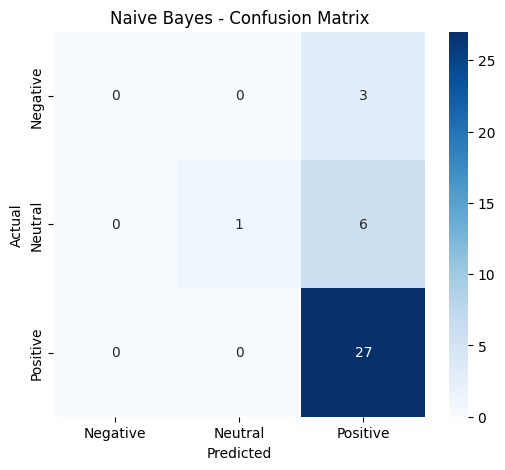


Training Random Forest
Accuracy: 0.811
              precision    recall  f1-score   support

    Negative       1.00      0.67      0.80         3
     Neutral       1.00      0.14      0.25         7
    Positive       0.79      1.00      0.89        27

    accuracy                           0.81        37
   macro avg       0.93      0.60      0.65        37
weighted avg       0.85      0.81      0.76        37



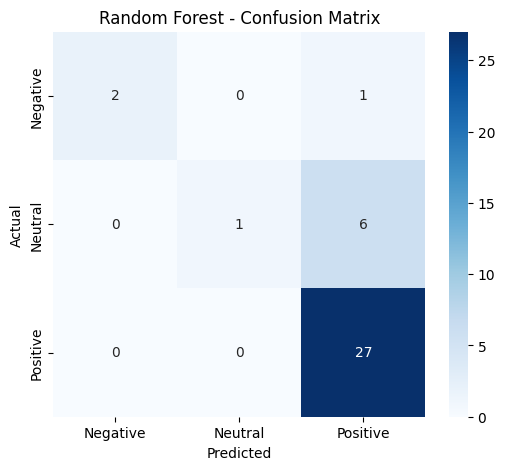

In [ ]:
models = {
    'Naive Bayes': MultinomialNB(),
    #for balancing the dataset
    'Random Forest': RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42)
}
results = {}
for name, model in models.items():
    print(f"\n{'='*50}\nTraining {name}\n{'='*50}")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"Accuracy: {accuracy:.3f}")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
    plt.figure(figsize=(6,5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()


### 7. Feature Importance
Display the most important words (features) for sentiment prediction in teaching feedback.


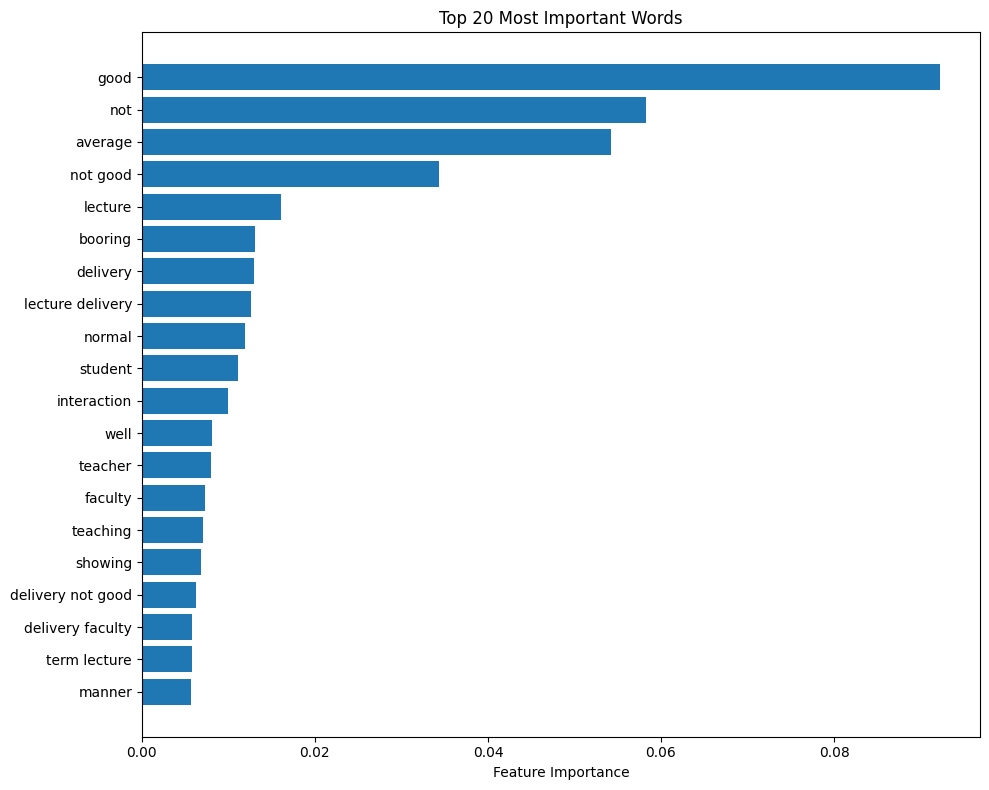

In [ ]:
rf_model = models['Random Forest']
feature_names = vectorizer.get_feature_names_out()
importances = rf_model.feature_importances_
top_features_idx = np.argsort(importances)[::-1][:20]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = importances[top_features_idx]

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_importances)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Words')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### 8. Make Predictions for New Feedback
Test the model on sample custom feedback and display predictions/confidence.


In [ ]:
# using built in lib ( my code needs improvement) (there is less dataset)
from textblob import TextBlob
text = "Poor quality, needs improvement"
blob = TextBlob(text)
print(blob.sentiment.polarity)  # < 0 means negative
print("using build in lib:","'Poor quality, needs improvement'")
print("\n")
def predict_sentiment(text, model=models['Random Forest'], vectorizer=vectorizer):
    processed_text = preprocess_text(text)
    text_tfidf = vectorizer.transform([processed_text])
    prediction = model.predict(text_tfidf)[0]
    probabilities = model.predict_proba(text_tfidf)[0]
    confidence = max(probabilities)
    sentiment_labels = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
    return {'text': text, 'sentiment': sentiment_labels[prediction], 'confidence': confidence}

sample_texts = [
    "The teaching is excellent and very interactive",
    "Average content, could be better",
    "Poor quality, bad lectures ",
    "Good facilities and helpful staff"
]



for text in sample_texts:
    result = predict_sentiment(text)
    print(f"Text: '{result['text']}'\nPrediction: {result['sentiment']} (confidence {result['confidence']:.3f})\n")


-0.4
using build in lib: 'Poor quality, needs improvement'


Text: 'The teaching is excellent and very interactive'
Prediction: Positive (confidence 0.960)

Text: 'Average content, could be better'
Prediction: Neutral (confidence 1.000)

Text: 'Poor quality, bad lectures '
Prediction: Positive (confidence 0.760)

Text: 'Good facilities and helpful staff'
Prediction: Positive (confidence 0.950)



### 9. Most Common Words by Sentiment
Show the top 10 frequent words used in negative, neutral, and positive teaching feedback.


In [ ]:
def analyze_common_words_by_sentiment():
    sentiment_words = {-1: [], 0: [], 1: []}
    for idx, row in df.iterrows():
        if pd.notna(row['teaching.1']) and pd.notna(row['teaching']):
            words = preprocess_text(row['teaching.1']).split()
            sentiment = row['teaching']
            sentiment_words[sentiment].extend(words)
    for sentiment, label in [(-1, 'Negative'), (0, 'Neutral'), (1, 'Positive')]:
        if sentiment_words[sentiment]:
            common_words = Counter(sentiment_words[sentiment]).most_common(10)
            print(f"{label} Sentiment - Top 10 words:")
            for word, count in common_words:
                print(f"  {word}: {count}")
            print()

analyze_common_words_by_sentiment()


Negative Sentiment - Top 10 words:
  not: 9
  good: 7
  lecture: 5
  term: 5
  teacher: 5
  delivery: 4
  dont: 4
  student: 4
  indian: 4
  subject: 3

Neutral Sentiment - Top 10 words:
  good: 20
  not: 14
  teaching: 13
  student: 13
  teacher: 11
  interaction: 10
  delivery: 7
  punctuality: 7
  lecture: 7
  average: 7

Positive Sentiment - Top 10 words:
  good: 117
  lecture: 20
  university: 19
  teacher: 17
  delivery: 15
  teaching: 13
  interaction: 12
  punctuality: 12
  punctual: 9
  student: 9



### 10. Model Performance Summary
Compare models and summarize results.


In [ ]:
print("Model accuracy scores:")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.3f}")

print(f"\nBest Model: {max(results, key=results.get)} ({max(results.values()):.3f})")


Model accuracy scores:
Naive Bayes: 0.757
Random Forest: 0.811

Best Model: Random Forest (0.811)


### Final Analysis


In [ ]:
# dataset is overll with positive sentiment,
"""  use of SMOTE for unbalanced dataset
    count vectorize with n gmram but i have used tfidf, which is for large documents to know about the
    importance of words
bhaiya ab nhi ho rha!

"""

'  use of SMOTE for unbalanced dataset\n    count vectorize with n gmram but i have used tfidf, which is for large documents to know about the \n    importance of words\n\n    \n'